In [66]:


import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

from sklearn.metrics import *
import scikitplot as skplt

from functools import partial
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [67]:
data = pd.read_csv('D:/semester3/test1_40/output_test.csv')
img_dir = 'D:/semester3/test1_40/'
class_names = ['benign', 'malignant']

In [68]:
data

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
...,...,...,...,...
39540,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...
39541,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...
39542,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...
39543,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...


In [69]:
data = data.loc[(data['mag'] == 40) & (data['fold']== 1)] 

In [70]:
data

,fold,mag,grp,filename
62,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
63,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
64,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
65,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
66,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
...,...,...,...,...
7869,1,40,test,BreaKHis_v2/histology_slides/breast/malignant/...
7870,1,40,test,BreaKHis_v2/histology_slides/breast/malignant/...
7871,1,40,test,BreaKHis_v2/histology_slides/breast/malignant/...
7872,1,40,test,BreaKHis_v2/histology_slides/breast/malignant/...


In [71]:
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(3)

,fold,mag,grp,path,label,label_int,filename
62,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-40-001.png
63,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-40-002.png
64,1,40,train,BreaKHis_v2/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-40-003.png


In [72]:
data_label = data.loc[data['label'] == 'benign'] 

In [73]:
data_label.count()

fold         625
mag          625
grp          625
path         625
label        625
label_int    625
filename     625
dtype: int64

In [74]:
data_label_m = data.loc[data['label'] == 'malignant'] 

In [75]:
data_label_m.count()

fold         1370
mag          1370
grp          1370
path         1370
label        1370
label_int    1370
filename     1370
dtype: int64

In [49]:
data.to_csv('D:/semester3/test1_40/updated_40_v2.csv')

In [76]:
data_updated_40_v2 = pd.read_csv('D:/semester3/test1_40/updated_40_v2.csv')

Count of Benign    :  625
Count of Malignant :  1370


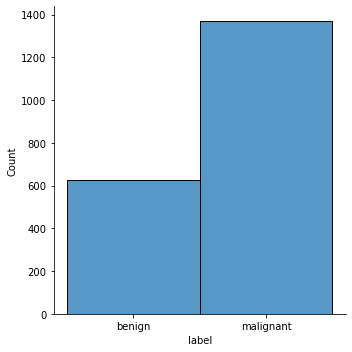

In [77]:
ax = sns.displot(data=data_updated_40_v2, x=data_updated_40_v2['label'])
print('Count of Benign    : ', data_updated_40_v2[data_updated_40_v2.label == 'benign'].label.count())
print('Count of Malignant : ', data_updated_40_v2[data_updated_40_v2.label == 'malignant'].label.count())

In [78]:
test_df = data_updated_40_v2.groupby('label').sample(frac=0.2)
train_df = data_updated_40_v2.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# split training and validation set
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df['set'] = 'test'
train_df['set'] = 'train'
valid_df['set'] = 'valid'
data_new = pd.concat([train_df,valid_df, test_df])
print(data_new)

# ax = sns.displot(data=data_new, x='label', col='set')

print('Training set')
print(train_df.label.value_counts())

print('\nValidation set')
print(valid_df.label.value_counts())

print('\nTest set')
print(test_df.label.value_counts())

     Unnamed: 0  fold  mag    grp  \
0            62     1   40  train   
1            66     1   40  train   
2            67     1   40  train   
3            68     1   40  train   
4            69     1   40  train   
..          ...   ...  ...    ...   
394        4521     1   40  train   
395        6628     1   40   test   
396        3969     1   40  train   
397        6306     1   40   test   
398        7133     1   40   test   

                                                  path      label  label_int  \
0    BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
1    BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
2    BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
3    BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
4    BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
..                                                 ...        ...        ..

In [79]:
print(train_df.label.value_counts())

malignant    888
benign       389
Name: label, dtype: int64


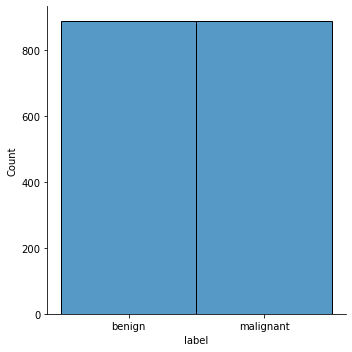

In [80]:
# upsampling training dataset
max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x=train_df['label'])

In [81]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))
test_loader=tf.data.Dataset.from_tensor_slices((img_dir+test_df.path, test_df.label_int))

In [82]:
model_handle_map = {

 "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

}


model_image_size_map = {

 "efficientnet_b0": 224

}

In [83]:
model_name = 'efficientnet_b0'
model_handle = model_handle_map.get(model_name)
IMAGE_SIZE = model_image_size_map.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_df)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnet_b0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Input size 224


In [84]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

In [85]:
def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return img, label

In [86]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))

train_ds = (
    train_loader.shuffle(len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
#     .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)
valid_ds = (
    valid_loader.shuffle(len(valid_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [87]:
def view_image(ds, col=8, row=2, size=(25,7)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for images, labels in ds.take(1):
        for i in range(col*row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

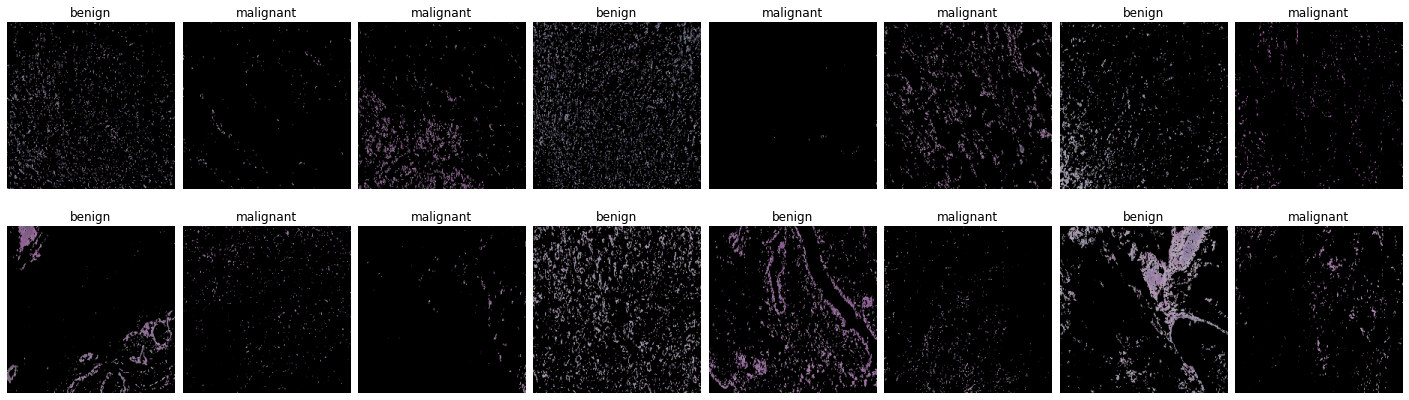

In [88]:
view_image(train_ds)

In [89]:
def build_network(image_size):
    print('building model...')
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base_model'),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid', name='classifier') 
    ],name=model_name)
    model.build((None, image_size, image_size, 3))
    model.summary()
    print('model loaded!!!')
    return model

In [90]:
tf.keras.backend.clear_session()
model = build_network(IMAGE_SIZE)



building model...
Model: "efficientnet_b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_model (KerasLayer)     (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                 

In [92]:

#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model_40.h5", save_best_only=True)
checkpoint_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=2e-05,  maximal_learning_rate=7e-3, 
    step_size=3*(SAMPLE_SIZE//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),

]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler) , 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
)

history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [checkpoint_cb],
    validation_data=valid_ds,
)

Epoch 1/12
28/28 [==============================] - 825s 28s/step - loss: 0.9974 - accuracy: 0.5332 - precision: 0.5330 - recall: 0.5372 - auc: 0.5392 - val_loss: 0.8512 - val_accuracy: 0.4984 - val_precision: 0.7400 - val_recall: 0.3558 - val_auc: 0.5537
Epoch 2/12
28/28 [==============================] - 838s 30s/step - loss: 0.8320 - accuracy: 0.6351 - precision: 0.6345 - recall: 0.6374 - auc: 0.6806 - val_loss: 0.8334 - val_accuracy: 0.5549 - val_precision: 0.7797 - val_recall: 0.4423 - val_auc: 0.6165
Epoch 3/12
28/28 [==============================] - 861s 31s/step - loss: 0.6721 - accuracy: 0.7511 - precision: 0.7424 - recall: 0.7691 - auc: 0.8163 - val_loss: 0.8104 - val_accuracy: 0.5987 - val_precision: 0.7500 - val_recall: 0.5769 - val_auc: 0.6474
Epoch 4/12
28/28 [==============================] - 836s 30s/step - loss: 0.5573 - accuracy: 0.8102 - precision: 0.7947 - recall: 0.8367 - auc: 0.8873 - val_loss: 0.7822 - val_accuracy: 0.6708 - val_precision: 0.8047 - val_recall: 0

In [93]:
def training_history(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(history['loss']))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    return None

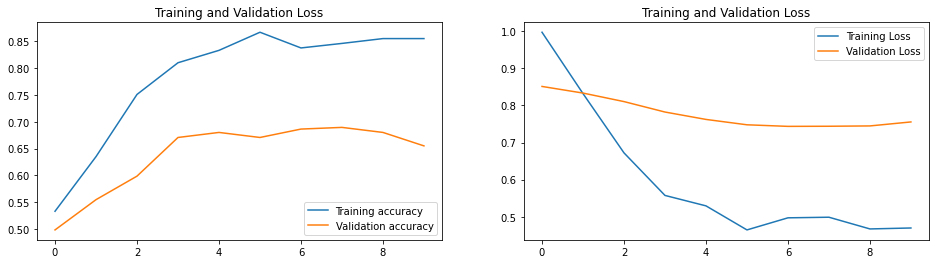

In [94]:
training_history(history.history)

In [95]:
def decode_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])/255
    return img

1/1 [==============================] - 21s 21s/step
              precision    recall  f1-score   support

      benign       0.49      0.68      0.57       125
   malignant       0.82      0.68      0.74       274

    accuracy                           0.68       399
   macro avg       0.66      0.68      0.66       399
weighted avg       0.72      0.68      0.69       399

f1_score        : 0.6766917293233082
accuracy_score  : 0.6766917293233082
precision_score  : 0.8222222222222222
recall_score  : 0.6751824817518248


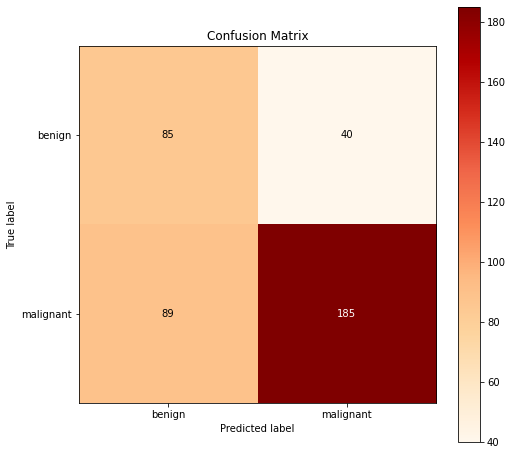

In [96]:
test_df = test_df.reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))
print('precision_score  :', precision_score(test_index, pred_index))
print('recall_score  :', recall_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False,cmap="OrRd")

In [97]:
print('f1_score        :', f1_score(test_index, pred_index))

f1_score        : 0.7414829659318638


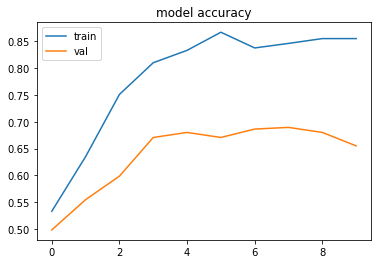

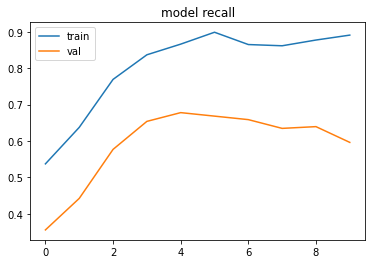

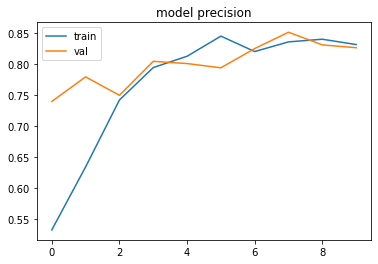

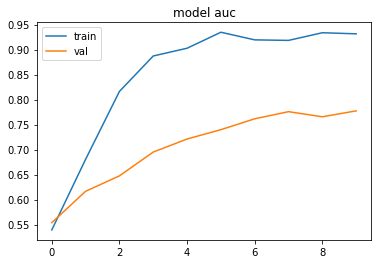

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plt.plot(history.history['f1_score'])
#plt.plot(history.history['val_f1_score'])
#plt.title('model f1_score')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

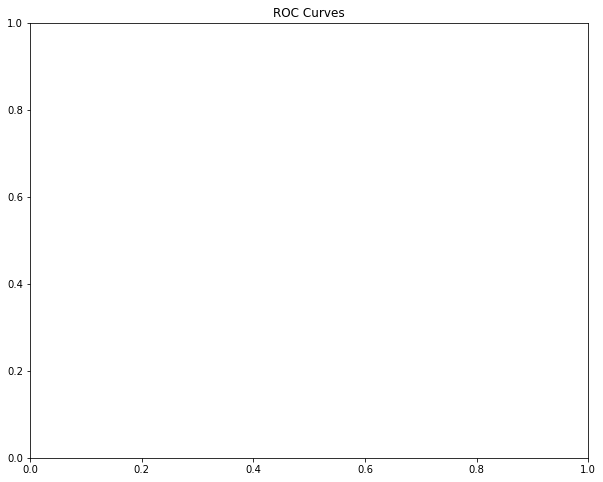

In [46]:
roc = skplt.metrics.plot_roc( test_pred,test_index, figsize=(10,8))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 435s 435s/step
              precision    recall  f1-score   support

      benign       0.99      0.99      0.99       625
   malignant       1.00      0.99      1.00      1370

    accuracy                           0.99      1995
   macro avg       0.99      0.99      0.99      1995
weighted avg       0.99      0.99      0.99      1995

f1_score        : 0.993483709273183
accuracy_score  : 0.993483709273183


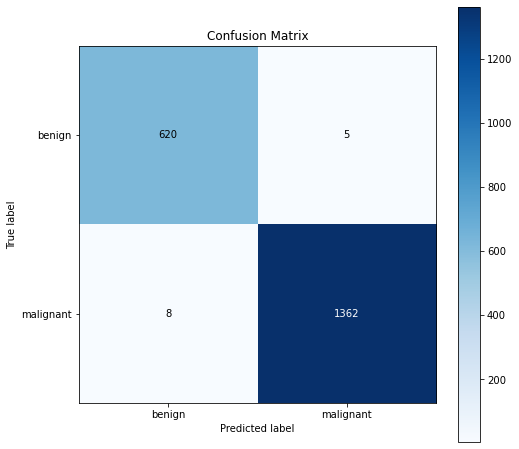

In [47]:
test_df = test_df.reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False)

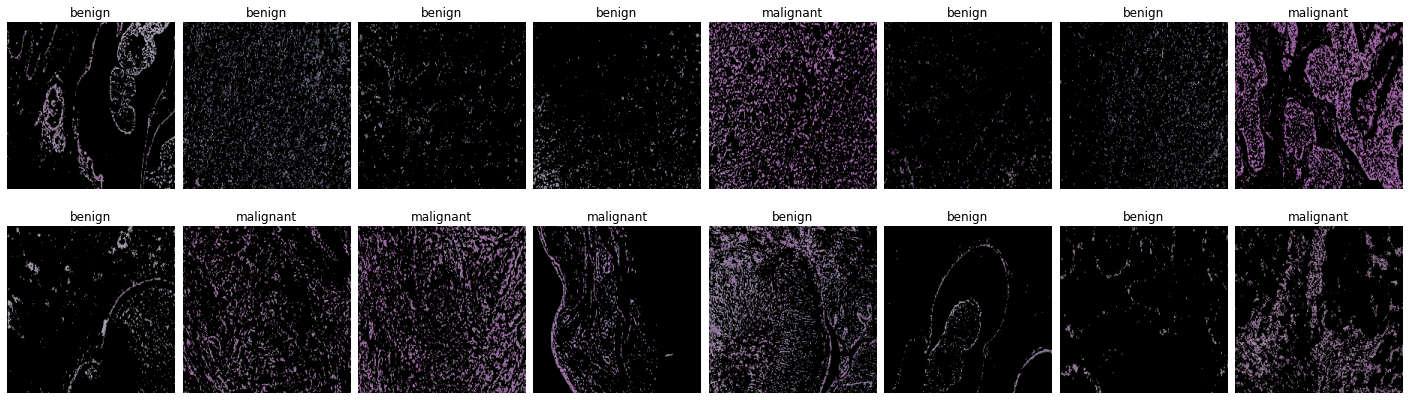